# Setup

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from datetime import datetime

Default "reasonable" parameter values based on those used to produce the exponential distribution in Lecheval

In [30]:
#Parameters for the simulation
N      = 1000           # Total number of ants

#Parameters from the equation, accessed by name
p    = {
"alpha"  : 0.75,            # Per capita rate of spontaneous discoveries
"s"      : 3.5,             # Per capita rate of ant leaving trail per distance
"gamma1" : 0.1,             # Range of foraging scouts
"gamma2" : 0.021,           # Range of recruitment activity
"gamma3" : 0.021,           # Range of influence of pheromone
"K"      : 1,               # Inertial effects that may affect pheromones
"n1"     : 20,              # Individual ant's contribution to rate of recruitment (orig. eta1)
"n2"     : 20               # Pheromone strength of trail (originally eta2)       
}

Default time to numerically integrate over

In [55]:
start = 0.0
stop  = 3000   
step  = 0.005
tspan = np.arange(start, stop+step, step)

Returns a system differential equations representing the change in number of ants on each trail

In [5]:
def dx_dt(x, t, Q,D,betaB,betaS,J):
        """
        Creates a list of J equations describing the number of ants
        on each of the J trails. (Eqn i corresponds to food source i)
        """
        system = np.zeros(J)
        system = (p["alpha"]* np.exp(-p["gamma1"]*D) + (p["gamma2"]/D)*betaB*x)*(N-sum(x)) - (p["s"]*D*x)/(p["K"]+ (p["gamma3"]/D)*betaS*x)
        return system


Numerically integrates the system of trails with given quality and distances

In [6]:
def simulation(Q, D, tspan = tspan, x0 = np.empty(0)):
    """
    Returns the results of numerically integrating the system
    with the input distances and qualities over the given time span
    returns an array of the number of ants on each trail over time
    """
    betaB = p["n1"] * Q
    betaS = p["n2"] * Q
    J = len(Q)
    if not x0.any():
        x0 = np.zeros(J)
    #Numerically integrates. Columns: trail, Rows: time step
    xs = odeint(dx_dt, x0, tspan, args=(Q,D,betaB,betaS,J)) 

    return xs

Numerically solves for the non-trivial equilibrium points of the system. That is, the point at which no single food source dominates and the number of ants on each trail has reached steady state. The default initial guess is that this equilibrium occurs when an equal proportion of all available ants are on each trail.

In [7]:
def find_eq_point(Q, D, guess = None):
    print(N)
    betaB = p["n1"] * Q
    betaS = p["n2"] * Q
    J = len(Q)
    
    if guess == None:
        guess = np.repeat(N/J, J)
        
    #The None is necessary here because dx_dt must take in a time
    #input when using odeint even though it is autonomous.
    eq = fsolve(dx_dt, guess, args=(None, Q, D, betaB, betaS, J))
    return eq

#Testing
#find_eq_point(np.array([5,10,10]), np.array([20,20,20]))

Plot the results of numerically integrating on a time axis

In [26]:
def plot_integrate(xs, Q, D, display=True, save=False):
    """
    Plots the results of numerical integration from integrate
    """

    fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
    total_ants = np.zeros(len(xs[0]))
    for i in range(len(xs[0])):
        ax.plot(tspan, xs[:,i], label=f"Trail {i}")
    ax.plot(tspan, np.sum(xs, axis=1), label="Total Ants on Trail", linestyle="dashed")
    #Find point at which we are using pretty much all the ants
    all_ants = 0
    for i in range(len(xs)):
        if np.sum(xs, axis=1)[i] > 0.99*N:
            all_ants = tspan[i]
            break
    ax.axvline(x = all_ants, linestyle ="dashed")
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Ants")
    ax.set_title("Number of ants on trails over time")
    plt.ylim([0, N])
    if save:
        plt.savefig(f"Plots/Plot-{datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')}.png")
    if display:
        plt.show()

Plot the results of numerically integrating 2 trails in phase space

In [9]:
def plot_2dphase(xs_array, Q, D, display=True, save=False):
    """
    Plot the results of numerical integration from integrate in phase space
    """
    fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)

    for i in range(len(xs_array)):
        xs = xs_array[i]
        if i == 0:
             ax.plot(xs[:,0], xs[:,1], color="black")
        else:
             ax.plot(xs[:,0], xs[:,1], color="red")
            
    ax.set_xlabel(f"Trail A (Q:{Q[0]} D:{D[0]})")
    ax.axhline(y = 0, color = "black")
    ax.axvline(x = 0, color ="black")

    ax.set_ylabel(f"Trail B (Q:{Q[1]} D:{D[1]})")
    ax.set_title("Ants on trails phase space")
    #Draw dotted line that represents the points at which all ants are on the trail
    #ax.plot([0, N], [N, 0], linestyle="--")
    #ax.set_aspect('equal', 'box')    
    if save:
        plt.savefig(f"Plots/Plot-{datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')}.png")
    if display:
        plt.show()

In [10]:
def plot_2dphase_norm(xs_array, Q, D, display=True, save=False):
    """
    Plot the results of numerical integration from integrate in phase space
    """
    fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
    xs_array /= N
    for i in range(len(xs_array)):
        xs = xs_array[i]
        if i == 0:
             ax.plot(xs[:,0], xs[:,1], color="black")
        else:
             ax.plot(xs[:,0], xs[:,1], color="red")
            
    ax.set_xlabel(f"Trail A (Q:{Q[0]} D:{D[0]})")
    ax.axhline(y = 0, color = "black")
    ax.axvline(x = 0, color ="black")

    ax.set_ylabel(f"Trail B (Q:{Q[1]} D:{D[1]})")
    ax.set_title("Ants on trails phase space")
    
    plt.xlim([0,1])
    plt.ylim([0,1])
    #Draw dotted line that represents the points at which all ants are on the trail
    #ax.plot([0, N], [N, 0], linestyle="--")
    #ax.set_aspect('equal', 'box')    
    if save:
        plt.savefig(f"Plots/Plot-{datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')}.png")
    if display:
        plt.show()

# Testing

Start by definining our qualities and distances and then finding the equilibrium point and integrating backwards to obtain a separatrix. 

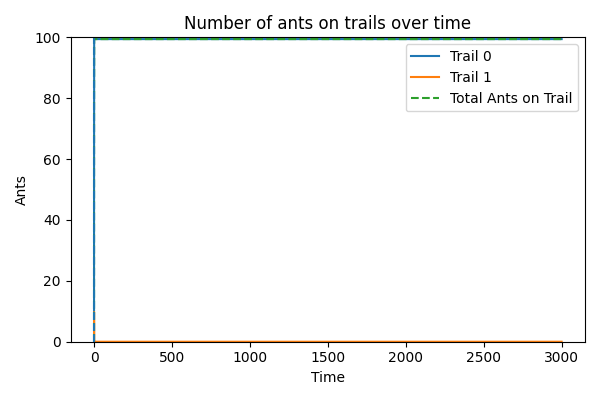

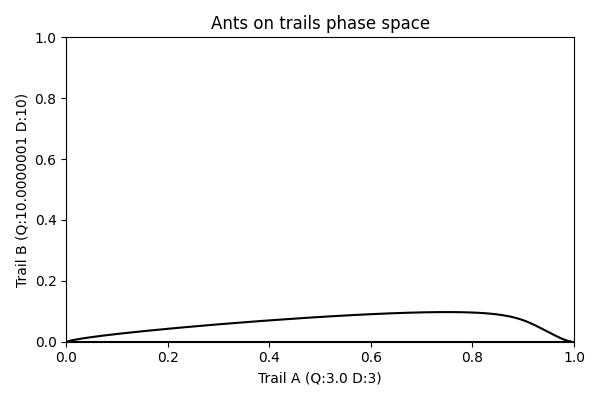

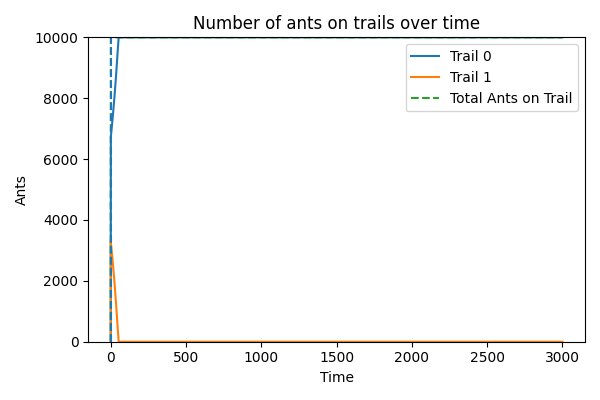

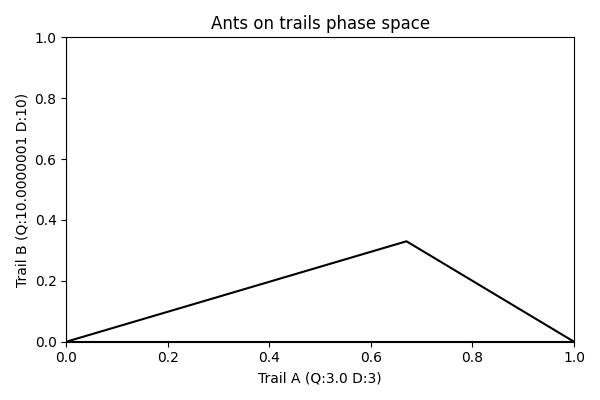

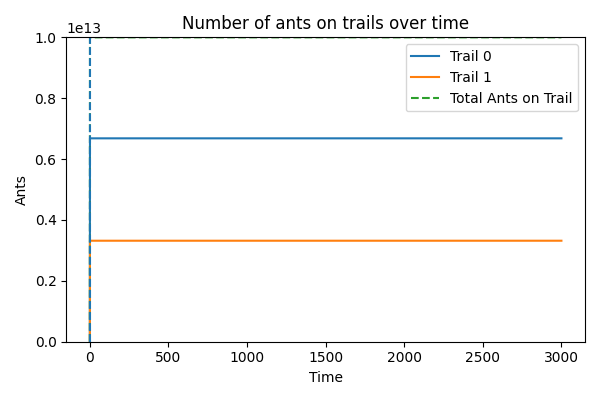

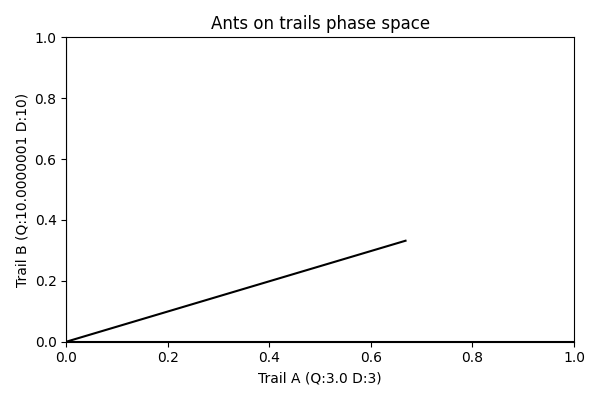

In [56]:
%matplotlib widget

Q = np.array([3, 10.0000001])
D = np.array([3, 10])

N = 100
#Define qualities and distances
xs = simulation(Q, D, tspan = tspan, x0 = np.array([0,  0]))
plot_integrate(xs, Q, D)
plot_2dphase_norm(np.array([xs]), Q, D)


N = 10000
#Define qualities and distances
xs = simulation(Q, D, tspan = tspan, x0 = np.array([0,  0]))
plot_integrate(xs, Q, D)

plot_2dphase_norm(np.array([xs]), Q, D)

N = 10000000000000
#Define qualities and distances
xs = simulation(Q, D, tspan = tspan, x0 = np.array([0,  0]))
plot_integrate(xs, Q, D)

plot_2dphase_norm(np.array([xs]), Q, D)

## Ant Zone

100000000000000000000000
[5.e+22 5.e+22]


c:\users\zbtra\appdata\local\programs\python\python39\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


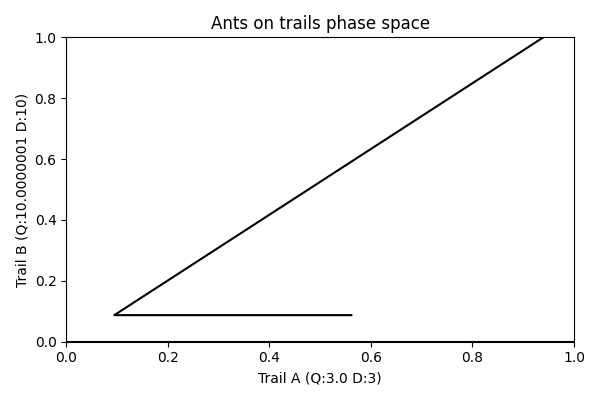

In [45]:
%matplotlib widget

eq = find_eq_point(Q, D)
print(eq)
N = 1000
xs_array = np.zeros((1, len(tspan), 2))
#Integrate backwards to get separatrix
sep = simulation(Q, D, tspan = np.flip(tspan), x0 = eq)
xs_array[0] = sep

#plot_integrate(np.flip(sep, 0), Q, D)
#plot_integrate(xs, Q, D)
plot_2dphase_norm(xs_array, Q, D)

Effect of population size on eq point location

100
1100
2100
3100
4100
5100
6100
7100
8100
9100
10100
11100
12100
13100
14100
15100
16100
17100
18100
19100
20100
21100
22100
23100
24100
25100
26100
27100
28100
29100
30100
31100
32100
33100
34100
35100
36100
37100
38100
39100
40100
41100
42100
43100
44100
45100
46100
47100
48100
49100
50100
51100
52100
53100
54100
55100
56100
57100
58100
59100
60100
61100
62100
63100
64100
65100
66100
67100
68100
69100
70100
71100
72100
73100
74100
75100
76100
77100
78100
79100
80100
81100
82100
83100
84100
85100
86100
87100
88100
89100
90100
91100
92100
93100
94100
95100
96100
97100
98100
99100
100100
101100
102100
103100
104100
105100
106100
107100
108100
109100
110100
111100
112100
113100
114100
115100
116100
117100
118100
119100
120100
121100
122100
123100
124100
125100
126100
127100
128100
129100
130100
131100
132100
133100
134100
135100
136100
137100
138100
139100
140100
141100
142100
143100
144100
145100
146100
147100
148100
149100
150100
151100
152100
153100
154100
155100
156100
157100
15810

Text(0.5, 1.0, 'Equilibrium point normalized by population size. Start is Red. Q=[25 10]. D=[10  5]')

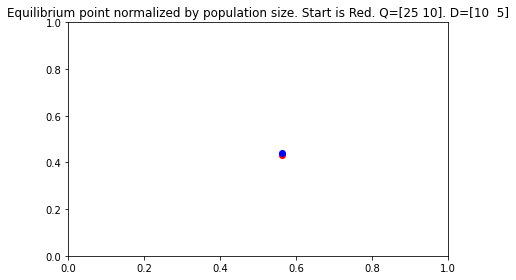

In [14]:
points = []
Q = np.array([25, 10])
D = np.array([10,  5])
for i in range(100, 10**6, 1000):
    N = i
    points.append(find_eq_point(Q, D)/N)

print(points)
#Plot
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
trail1 = [point[0] for point in points]
trail2 = [point[1] for point in points]
ax.plot(trail1, trail2)
ax.plot(trail1[0], trail2[0], color="red", marker="o")
ax.plot(trail1[-1], trail2[-1], color="blue", marker="o")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.title(f"Equilibrium point normalized by population size. Start is Red. Q={Q}. D={D}")
